# Classificação de Gênero Musical

### 1. Problema a ser resolvido
Classificação de gênero musical: 
1. Utilizando Dados extraídos dos espectogramas das musicas
2. Utilizando as próprias imagens dos espectogramas


### 2. Dataset
#### GTZAN dataset

10 Gêneros Musicais
1. Blues
2. Classical
3. Country
4. Disco
5. Hiphop
6. Jazz
7. Metal
8. Pop
9. Reggae
10. Rock


Cada gênero contém 100 musicas. Total dataset: 1000 musicas. (1.2 GB)
Para cada música foi criado uma imagem (12x12) do espectograma equivalente da musica. (276.6MB)
Para a extração de dados do espectograma foram selecionados as principais                                 features de extração da biblioteca Librosa, que são:

1. Mel-frequency cepstral coefficients (20 coeficientes):
Representação de um conjunto dos espectros de potência de cada faixa de um som
2. Spectral Centroid:
Medida de processamento digital de sinais para caracterizar um espectro. Indica onde está localizado o "centro de massa" do espectro. 
3. Zero Crossing Rate:
Taxa de mudanças de sinal ao longo de um sinal, ou seja, a taxa na qual o sinal muda de positivo para zero para negativo ou de negativo a zero a positivo.
4. Chroma Frequencies:
Medida que abstrai os sinais detectados e os aproximam das classes de notas harmônicas
5. Spectral Roll-off:
Medida que utiliza uma função da frequência logarítmica com as unidades representadas como decibéis ao longo das faixas.



In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Criando o espectograma a partir dos audios

In [2]:
%%time
#Mapa de calor do spec
cmap = plt.get_cmap('plasma')
#Tamanho da figura resultante
plt.figure(figsize=(12,12))

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
#Criando a pasta de cada diretorio pra suas imagens
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    #Buscando no diretorio dos audios e fazendo a criação do espectograma
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=10)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

CPU times: user 28min 34s, sys: 8.45 s, total: 28min 43s
Wall time: 8min 45s


<Figure size 864x864 with 0 Axes>

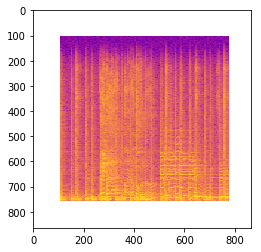

In [3]:
import cv2
imgSpec = cv2.imread('img_data/blues/blues00001.png')
imgSpec = cv2.cvtColor(imgSpec, cv2.COLOR_BGR2RGB)
plt.imshow(imgSpec); plt.show()

### Criando um .csv, a partir dos espectogramas utilizando as features escolhidas

In [4]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [5]:
%%time
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'genres/{g}'):
        songname = f'genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

CPU times: user 57min 11s, sys: 1min 40s, total: 58min 51s
Wall time: 20min 58s


### Analise Exploratória dos dados

In [6]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00013.au,0.264616,1324.304356,1827.737535,2710.033613,0.051417,-209.789266,124.458449,10.310380,47.018006,...,-2.205935,-3.038192,8.645516,-0.304230,-0.637744,-2.939885,-1.705923,-1.769590,-7.762958,blues
1,blues.00044.au,0.390212,2279.124558,2375.102120,5198.360233,0.092570,-109.509285,86.922406,-8.607986,64.494557,...,11.087480,-5.085794,3.976359,-12.859741,12.343857,0.026217,-0.741570,-5.126619,3.303441,blues
2,blues.00018.au,0.269929,1537.657183,2054.779113,3495.653862,0.056132,-252.533986,104.927485,15.353578,42.656638,...,1.960557,-0.881435,7.778604,2.390255,1.774140,1.339317,3.630699,4.910860,-2.651944,blues
3,blues.00028.au,0.275974,1115.729116,1398.954704,2290.444483,0.048028,-248.967653,139.038459,-16.249238,57.098117,...,-2.844094,-0.893325,-2.401651,2.572721,-5.873962,-12.408275,-7.301892,-0.932405,-2.699273,blues
4,blues.00076.au,0.365575,2645.681661,2426.198512,5612.507729,0.136469,-52.693061,74.430284,-18.692437,56.323873,...,7.792499,-10.561926,6.946956,-9.127867,13.020091,-9.854002,3.689460,-4.947726,4.426066,blues


In [9]:
data.tail()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
995,rock.00058.au,0.301092,2437.399429,2789.821383,5497.725089,0.098943,-141.984890,96.997318,23.241800,10.453830,...,-2.016179,-5.892612,-6.021554,-2.120564,-6.166340,-0.326774,5.096092,0.124513,1.674481,rock
996,rock.00090.au,0.255691,2495.737423,2249.869714,5213.168477,0.120643,-89.024086,86.200578,-24.400166,47.094960,...,7.481489,-12.851751,8.588623,-7.891173,11.490477,0.681784,9.796061,-2.127682,0.589409,rock
997,rock.00071.au,0.454292,2025.045157,2215.382497,4571.205692,0.090808,-79.809090,109.923227,-17.112701,47.178773,...,13.030406,-11.579700,9.104020,-5.953490,4.914147,-8.710204,3.701960,-5.099721,2.622137,rock
998,rock.00034.au,0.421082,2789.712144,2648.716877,5836.164710,0.135008,-28.061826,65.631668,-7.352339,33.593664,...,3.189335,-1.685570,-0.161785,-1.691113,1.850430,-3.969524,-1.626862,-6.389011,-3.863663,rock
999,rock.00072.au,0.403287,1933.518476,2211.281522,4359.906970,0.081729,-95.307878,112.446491,-2.083334,47.050788,...,11.874564,-11.191177,8.876775,-4.945704,0.924623,-6.106566,3.237717,-8.072705,0.733370,rock


In [8]:
data.shape

(1000, 27)

In [10]:
data.describe()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378669,2201.834226,2242.559613,4571.702159,0.103637,-144.479173,99.552199,-8.921949,36.293063,-1.146627,...,-6.021121,4.471604,-4.797232,1.781547,-3.870275,1.147988,-3.967431,0.507303,-2.328779,-1.094875
std,0.081706,715.961347,526.337663,1574.770035,0.041834,100.235661,31.331904,21.695015,16.666987,12.222555,...,6.819018,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561
min,0.171782,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,-89.901142,-18.768461,-38.903451,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,0.319641,1627.793931,1907.136505,3380.956639,0.070281,-200.695133,76.811480,-24.223791,24.107395,-9.974552,...,-10.966826,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194297,-2.003979,-4.670281,-3.368000
50%,0.383075,2209.468780,2221.408983,4658.671830,0.099539,-120.206072,98.452551,-10.716073,36.957074,-0.015239,...,-5.920161,3.891842,-4.199810,1.879424,-3.614473,1.211944,-4.059109,0.669788,-2.391261,-1.155198
75%,0.435974,2691.969702,2578.474352,5534.197785,0.132007,-73.895019,119.893638,5.505793,48.212826,7.920911,...,-1.004241,9.706133,-0.161017,5.155264,-0.323536,4.350694,-0.842968,3.112518,0.149070,1.303739
max,0.663573,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,56.666090,80.691273,31.461661,...,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


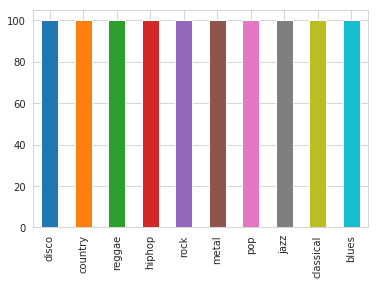

In [12]:
data['label'].value_counts().plot(kind='bar');

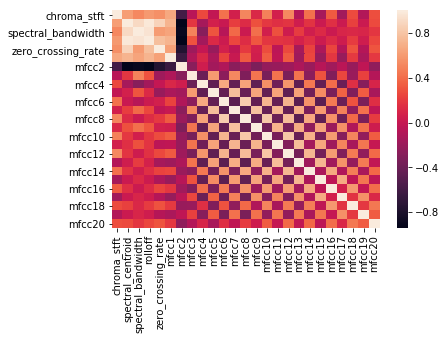

In [11]:
import seaborn as sns
sns.heatmap(data.corr())
sns.set_style("whitegrid")
plt.show()